<a href="https://colab.research.google.com/github/GermanOmar/Wear/blob/master/Wear_HV_Metals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A machine learning approach for microhardness prediction and sliding wear evaluation in materials manufactured by laser powder bed fusion

<a href="https://ibb.co/3vvDZtg"><img src="https://i.ibb.co/Nrr8Bwc/Tests2-TIFF.png" WIDTH="620" HEIGHT="360"  border="0"></a>

 Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

Randomized search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

 Upload database:

In [ ]:
!git clone https://github.com/GermanOmar/Wear

Cloning into 'Wear'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 40 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [ ]:
#Experimental data
data = pd.read_table('HV.txt') 
data.describe()


,Power,Speed,Height,Hatch,Density,Microhardness
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,192.916667,783.208333,45.625000,68.958333,5.532083,413.363889
std,108.863366,692.551090,8.996772,26.269694,2.292337,226.369520
min,80.000000,56.000000,20.000000,40.000000,2.340000,118.000000
25%,100.000000,250.000000,50.000000,50.000000,2.590000,186.300000
50%,150.000000,500.000000,50.000000,60.000000,5.165000,394.100000
75%,280.000000,1000.000000,50.000000,80.000000,7.800000,540.825000
max,500.000000,2500.000000,50.000000,120.000000,8.010000,980.300000



Setting inputs - output:

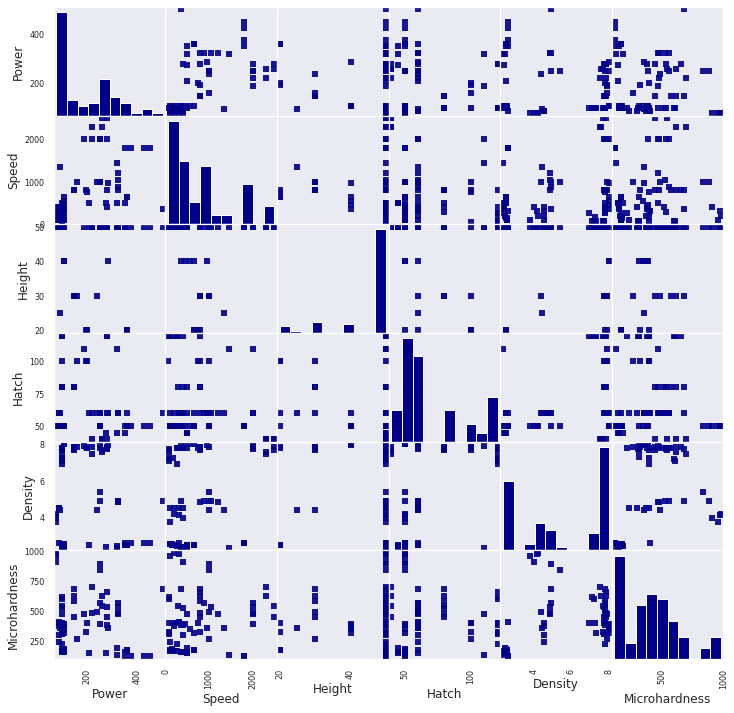

In [ ]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
import seaborn as sns
sns.set()

plt.rcParams["axes.grid"] = False

#pd.tools.plotting.scatter_matrix(df, alpha=0.2, c='red', hist_kwds={'color':['burlywood']})

#scatter_matrix(data, alpha=0.2, marker='s', figsize = (12,12), color = 'blue')
scatter_matrix(data, alpha=0.9,marker='s', figsize = (12,12),  c='darkblue', hist_kwds={'color':['darkblue']})

warnings.filterwarnings("ignore")

In [ ]:
#X=data[['P', 'S', 'L',  'HD1',  'F', 'd' ]]
X=data[['Power', 'Speed', 'Height', 'Hatch', 'Density']]
Y=data['Microhardness'][:,None]

# Hardness prediction

 Split data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4321)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 57  test samples: 15


In [ ]:
YTR=np.mean(y_train)
YTR

413.31228070175433

In [ ]:
YT=np.mean(y_test)
YT

413.56

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#y_train = scaler.fit_transform(y_train)
#y_test = scaler.transform(y_test)


###Results:

### XGB

In [ ]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=20, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=4321,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

-XGBRegressor -
------------------
MSE test: 12008.982019649027

R2:  0.7333517034603498
RMSE:  109.58550095541393
MAE:  67.50265146891276
IM:  128.707657411269



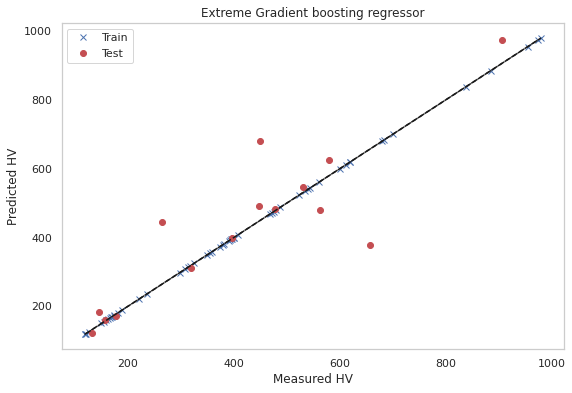

In [ ]:
print("-XGBRegressor -")
print("------------------")
y_star_train = xgbr.predict(X_train)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted HV')
plt.xlabel('Measured HV')
plt.title("Extreme Gradient boosting regressor")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

In [ ]:
# get importance

importance = xgbr.feature_importances_
# summarize feature importance

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance


Feature: 0, Score: 0.23504
Feature: 1, Score: 0.02049
Feature: 2, Score: 0.00013
Feature: 3, Score: 0.29102
Feature: 4, Score: 0.45332


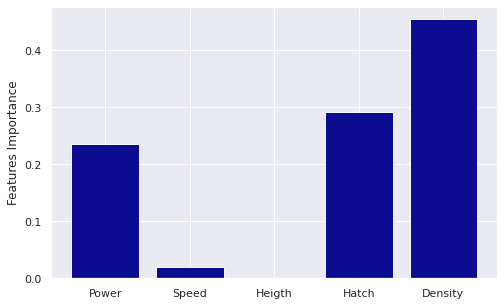

In [ ]:
# Create lists for the plot
import seaborn as sns
sns.set()

#plt.rcParams["axes.grid"] = False

labels = ['Power', 'Speed', 'Heigth', 'Hatch', 'Density' ]
x_pos = np.arange(len(labels))

fig, ax = plt.subplots()
fig.set_size_inches((8,5))

ax.bar(x_pos, importance, align='center', alpha=0.95, color='darkblue')
ax.set_ylabel('Features Importance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Features Importance Analysis')
ax.yaxis.grid(True)


## GBR

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=1000, random_state=42, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train, y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()


-Gradient boosting regressor-
-----------------------------
MSE test: 11576.328438937604

R2:  0.7429583745420217
RMSE:  107.59334755893417
MAE:  71.08795625035667
IM:  128.9569386779457



## ADA

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(random_state=42, n_estimators=1000)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

 AdaBoost -
------------------
MSE test: 7876.726392560944

R2:  0.8251046032504041
RMSE:  88.75092333356845
MAE:  66.80983428057212
IM:  111.086952148118



## RFR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
RFR=RandomForestRegressor(n_estimators=2000,max_depth=20)

#START TRAINING
RFR.fit(X_train,y_train)
#PREDICTION
y_pred=RFR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-----------------------------
MSE test: 9046.755465495948

R2:  0.7991251939474745
RMSE:  95.11443352875497
MAE:  64.0484266666685
IM:  114.66907505800884



## Comparisson

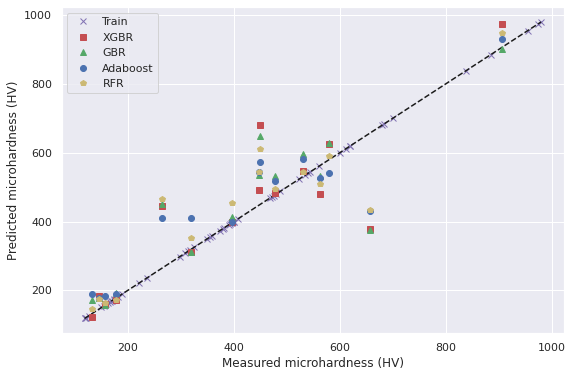

In [ ]:
import seaborn as sns
sns.set()

y1=xgbr.predict(X_test)
y2=GBR.predict(X_test)
y3=Ada.predict(X_test)
y4=RFR.predict(X_test)

#Plots
#sns.set_theme(style="whitegrid")
#sns.set_theme(style="darkgrid")
plt.rcParams["axes.grid"] = True
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'mx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y1, 'rs', label = 'XGBR')
plt.plot(y_test, y2, 'g^', label = 'GBR')
plt.plot(y_test, y3, 'bo', label = 'Adaboost')
plt.plot(y_test, y4, 'yp', label = 'RFR')

plt.legend()
plt.ylabel('Predicted microhardness (HV)')
plt.xlabel('Measured microhardness (HV)')
#plt.title("Machine learning regressors")
print()

### CROSS-VALIDATION

In [ ]:

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [ xgbr,  GBR, Ada, RFR ]
labels = ['XGBR',  'GBR', 'Adaboost', 'RFR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  #y_star = mod.predict(X)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.7515 | 11305.1648 | 74.6599 | 129.9204 
            GBR | 0.7170 | 12053.8045 | 76.7834 | 133.9760 
       Adaboost | 0.7669 | 10315.6130 | 74.8657 | 126.1766 
            RFR | 0.7291 | 11597.1705 | 80.8192 | 134.6439 
--------------------------------------------------------------


## Predictions


In [ ]:
#X=data[['P', 'v', 'L', 'H', 'RD', 'HV1', 'HV2']]
prediction1 = Ada.predict([[160,	700, 30, 60, 7.74,  ]])
print(prediction1)

ValueError: ignored

# Wear evaluation

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Experimental data
data = pd.read_table('wear.txt') 
data.describe()

,LP,SS,LT,RD,HBM,HCB,F,D,w,K
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000
mean,173.870968,591.895161,44.354839,5.762581,439.427419,1229.274194,9.653226,158.173042,2.880145,10.420758
std,117.910147,523.769677,8.419526,2.167730,218.076880,645.368878,14.458870,76.361416,3.321766,11.435778
min,25.000000,55.600000,20.000000,2.400000,145.000000,600.000000,3.000000,70.371675,0.003000,0.014000
25%,100.000000,200.000000,40.000000,4.342500,309.250000,746.000000,3.000000,105.557513,0.429750,1.168500
50%,110.000000,400.000000,50.000000,4.990000,399.500000,830.000000,4.950000,133.203529,1.470000,7.363000
75%,247.500000,800.000000,50.000000,7.872500,538.500000,1601.500000,5.750000,211.115026,4.391750,14.517750
max,800.000000,2000.000000,50.000000,8.010000,980.300000,2800.000000,50.000000,592.500000,11.900000,48.305000


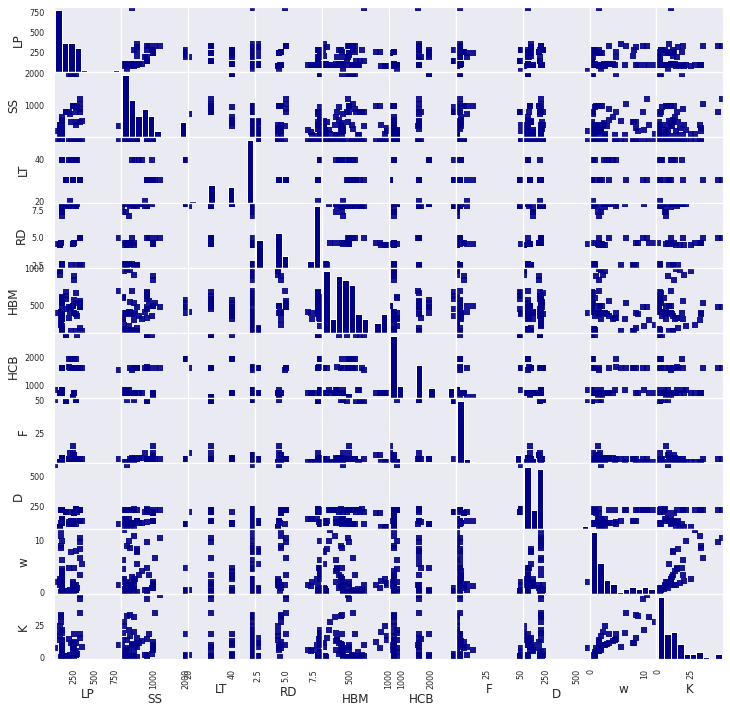

In [ ]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
import seaborn as sns
sns.set()

plt.rcParams["axes.grid"] = False

#pd.tools.plotting.scatter_matrix(df, alpha=0.2, c='red', hist_kwds={'color':['burlywood']})

#scatter_matrix(data, alpha=0.2, marker='s', figsize = (12,12), color = 'blue')
scatter_matrix(data, alpha=0.9,marker='s', figsize = (12,12),  c='darkblue', hist_kwds={'color':['darkblue']})

warnings.filterwarnings("ignore")

In [ ]:
#X=data[[ 'HBM', 'HCB', 'F','D', 'K']]
X=data[['LP','SS', 'RD', 'HBM', 'HCB', 'K']]
Y=data['w'][:,None]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4321)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 49  test samples: 13


In [ ]:
YW1=np.mean(y_train)
YW1

2.869795918367347

In [ ]:
YW2=np.mean(y_test)
YW2

2.9191538461538467

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

XGBR

In [ ]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=4321,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)


In [ ]:
print("-XGBRegressor -")
print("------------------")
y_star_train = xgbr.predict(X_train)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 1.132759548943112

R2:  0.8821708585118081
RMSE:  1.064311772434709
MAE:  0.7051873945456285
IM:  1.2821593180853184



In [ ]:
# get importance

importance = xgbr.feature_importances_
# summarize feature importance

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance


Feature: 0, Score: 0.01161
Feature: 1, Score: 0.01275
Feature: 2, Score: 0.09616
Feature: 3, Score: 0.17203
Feature: 4, Score: 0.00066
Feature: 5, Score: 0.70679


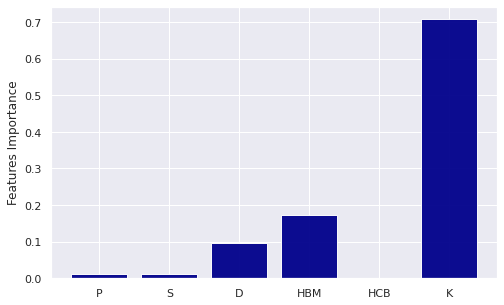

In [ ]:
# Create lists for the plot
import seaborn as sns
sns.set()

#plt.rcParams["axes.grid"] = False

#labels = [ 'LP','SS', 'LT', 'RD','HBM', 'HCB', 'F','d', 'K']
labels = [ 'P','S', 'D','HBM', 'HCB','K',]
#labels = [ 'HBM', 'HCB', 'F','D','K' ]
x_pos = np.arange(len(labels))


fig, ax = plt.subplots()
fig.set_size_inches((8,5))

ax.bar(x_pos, importance, align='center', alpha=0.95, color='darkblue')
ax.set_ylabel('Features Importance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title('Features Importance Analysis')
ax.yaxis.grid(True)

GBR

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=2000, random_state=42, learning_rate=0.1 )

#START TRAINING
GBR.fit(X_train, y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-Gradient boosting regressor-
-----------------------------
MSE test: 0.29467630445933657

R2:  0.9693479026473425
RMSE:  0.5428409568734995
MAE:  0.433895861737456
IM:  0.6956158957099405



AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(random_state=42, n_estimators=2000)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

 AdaBoost -
------------------
MSE test: 0.7428655448354367

R2:  0.9227274583818024
RMSE:  0.8618964815077484
MAE:  0.6192688355504143
IM:  1.0641101828323694



GPR

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(alpha=0.001, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=40, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=42)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

Gaussian Process
MSE train: 0.002003121334494148
MSE test: 0.2890535667585574
MSE train < MSE test? True

R2_train:  0.9998209150308692
R2_test:  0.9699327773073834

R2:  0.9699327773073834
RMSE:  0.5376370213801849
MAE:  0.4122522633931736
IM:  0.6781663021057589



C-V

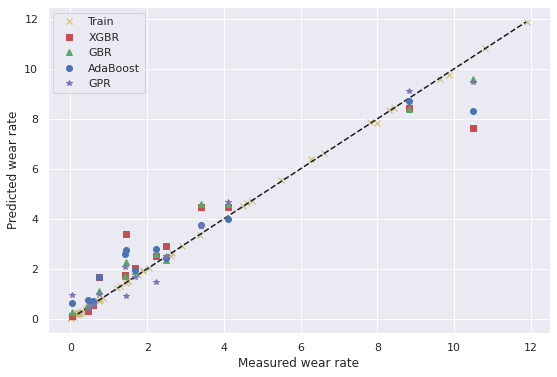

In [ ]:
import seaborn as sns
sns.set()

y1=xgbr.predict(X_test)
y2=GBR.predict(X_test)
y3=Ada.predict(X_test)
y4=GP.predict(X_test)
#Plots
#sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = True
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'yx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y1, 'rs', label = 'XGBR')
plt.plot(y_test, y2, 'g^', label = 'GBR')
plt.plot(y_test, y3, 'bo', label = 'AdaBoost')
plt.plot(y_test, y4, 'm*', label = 'GPR')


plt.legend()
plt.ylabel('Predicted wear rate')
plt.xlabel('Measured wear rate')
#plt.title("Machine learning regressors")
print()

In [ ]:

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [  xgbr, GBR, Ada, GP ]
labels = [ 'XGBR', 'GBR', 'Adaboost', 'GPR']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  #y_star = mod.predict(X)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.7082 | 2.7868 | 1.0201 | 1.9781 
            GBR | 0.8348 | 1.4469 | 0.6992 | 1.4011 
       Adaboost | 0.8763 | 1.2606 | 0.7590 | 1.3609 
            GPR | 0.9641 | 0.3630 | 0.3726 | 0.7093 
--------------------------------------------------------------


## Uncertainty quantification

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(alpha=0.001, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=40, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=1234)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
#Plots
sns.set_theme(style="darkgrid")
plt.rcParams["axes.grid"] = True
fig = plt.figure()
fig.set_size_inches((9,6))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Measured melting efficiency')
plt.title("Gaussian process regressor")
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

In [ ]:
X=data['K'][:,None]
Y=data['w'][:,None]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

Analitical model

In [ ]:
def f(x):
  #return  2.9321*x + 1.9759
  return  0.2166*x + 0.5047

Xs = np.linspace(0.014,48.31,30)
Ys=f(Xs)
plt.figure()
plt.figure(figsize =(9, 6))
plt.plot(Xs, Ys, 'k--',  label = 'Model')
plt.plot(X_train, y_train, 'b*', label = 'Train')
plt.plot(X_test, y_test, 'ro', label = 'Test')
plt.legend()
plt.xlabel('Wear coefficient')
plt.ylabel('Wear rate')

In [ ]:
#Tunning hiperparameters (Training data)
def f(x):
  #return 2.9321*x + 1.9759
  return  0.2166*x + 0.5047

X1 = np.asarray(X_train)
y1 = np.asarray(y_train).ravel()

x1 = np.atleast_2d(np.linspace(0.014,48.31,30)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
model = GPR(kernel=kernel, n_restarts_optimizer=8, alpha=0.5, normalize_y=True)

model.fit(X1, y1)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = model.predict(x1, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
plt.figure()
plt.figure(figsize =(9, 6)) 
plt.plot(x1, f(x1), 'k:', label=r'Empirical Model')
plt.plot(X1, y1, 'b.', markersize=10, label='Experimental data')
plt.plot(x1, y_pred, 'r-', label='Prediction')
plt.fill(np.concatenate([x1, x1[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.25, fc='y', ec='None', label='95% confidence interval')
plt.xlabel('Power (kW)')
plt.ylabel('WW (mm)')
plt.legend(loc='upper left')

In [ ]:
#Tunning hiperparameters (Testing data)
def f(x):
  return 0.2166*x + 0.5047

X2 = np.asarray(X)
y2 = np.asarray(Y).ravel()

x2 = np.atleast_2d(np.linspace(0.014,48.31,30)).T

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-3, 1e3))
model = GPR(kernel=kernel, n_restarts_optimizer=10, alpha=0.5 , normalize_y=True)

model.fit(X2, y2)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = model.predict(x2, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
plt.figure()
plt.figure(figsize =(9, 6)) 
plt.plot(x2, f(x2), 'k:', label=r'Analitical Model')
plt.plot(X_train, y_train, 'bo', label = 'Train')
plt.plot(X_test, y_test, 'ys', label = 'Test')
plt.plot(x2, y_pred, 'r-' , label='Prediction')
plt.fill(np.concatenate([x2, x2[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.1, fc='r', ec='None', label='95% confidence interval')
plt.xlabel('Wear rate ')
plt.ylabel('Wear coefficient ')
plt.legend(loc='upper left')